In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 22, 4
import time

import seaborn as sns
from sklearn import metrics, ensemble, tree, linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

# import xgboost as xgb

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE


# Load data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_y = train_df.pop('SalePrice') # take out y value
test_id = test_df.pop('Id') # for writing submission file
# also remove id column from train as it will not be used
train_df.drop('Id', axis = 1, inplace=True)

ERROR (theano.sandbox.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/sam/anaconda2/lib/python2.7/site-packages/theano/sandbox/gpuarray/__init__.py", line 95, in <module>
    init_dev(config.device)
  File "/home/sam/anaconda2/lib/python2.7/site-packages/theano/sandbox/gpuarray/__init__.py", line 46, in init_dev
    "Make sure Theano and libgpuarray/pygpu "
RuntimeError: ('Wrong major API version for gpuarray:', 1, 'Make sure Theano and libgpuarray/pygpu are in sync.')


In [2]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
print train_df.shape
print test_df.shape

(1460, 79)
(1459, 79)


In [4]:
# check number of nan in both train and test for each columns
def check_null(df):
    null_check = df.isnull().sum(axis=0)
    null = null_check[null_check!=0]
    null_df = df.isnull()
    return null, null_df
train_null, _ = check_null(train_df)
test_null, _ = check_null(test_df)
# print ">>>null value in train:\n", train_null
# print "\n>>>null value in test:\n", test_null

In [5]:
# get rid off columns with missing values more than half
drop_cols1 = [train_null.index[i] for i in range(train_null.shape[0]) if train_null.values[i] > train_df.shape[0]/2]
drop_cols2 = [test_null.index[i] for i in range(test_null.shape[0]) if test_null.values[i] > test_df.shape[0]/2]
drop_cols = list(set(drop_cols1+drop_cols2))
print drop_cols

['PoolQC', 'MiscFeature', 'FireplaceQu', 'Fence', 'Alley']


In [6]:
# finish drop and start impute rest missing data
train_df.drop(drop_cols, axis = 1, inplace=True)
test_df.drop(drop_cols, axis = 1, inplace=True)

# after dropping selected columns, we want to impute which requires
# data to be numeric value, so we proceed to convert categorical data
# but this conversion erases nan, so here we record where the nan is
_, train_nulls = check_null(train_df)
_, test_nulls = check_null(test_df)

In [7]:
# # convert object to categorical value first
# obj_columns = train_df.select_dtypes(['object']).columns
# num_columns = list(set(train_df.columns)-set(obj_columns))
# for col in obj_columns:
#     train_df[col] = train_df[col].astype('category')
#     test_df[col] = test_df[col].astype('category')
#     # same conversion should be applied to test data also
#     map_col = dict(zip(list(train_df[col].unique()), list(train_df[col].cat.codes.unique())))
#     # convert test_df categorical column
#     test_df[col] = test_df[col].apply(lambda x: map_col[x]).astype('int')
# #     print "Done", col

# # now convert train set
# train_df[obj_columns] = train_df[obj_columns].apply(lambda x: x.cat.codes)

In [8]:
# convert object to categorical value first
# record what columns are categorical and numeric columns
obj_columns = train_df.select_dtypes(['object']).columns
num_columns = list(set(train_df.columns)-set(obj_columns))

# just in case test set has more categories than train, concatenate them first for conversion
train_df.loc[:, 'temp'] = 'train'
test_df.loc[:, 'temp'] = 'test'
combined_df = pd.concat([train_df, test_df])

for col in obj_columns:
    combined_df[col] = combined_df[col].astype('category')
# now convert train set
combined_df[obj_columns] = combined_df[obj_columns].apply(lambda x: x.cat.codes)

# now split back to train and test
train_df = combined_df[combined_df['temp']=='train'].drop(['temp'], axis=1)
test_df = combined_df[combined_df['temp']=='test'].drop(['temp'], axis=1)

In [9]:
# get the nan back
train_df[train_nulls] = np.nan
test_df[test_nulls] = np.nan

In [10]:
# impute missing data

# train_filled = SimpleFill().complete(train_df)
# train_filled = SoftImpute().complete(train_df)
train_filled = KNN(k=5).complete(train_df)
# train_filled = MICE().complete(train_df)

# test_filled = SoftImpute().complete(test_df)
test_filled = KNN(k=5).complete(test_df)

train_filled = pd.DataFrame(train_filled, columns=train_df.columns)
test_filled = pd.DataFrame(test_filled, columns=test_df.columns)

Imputing row 1/1460 with 0 missing, elapsed time: 0.669
Imputing row 101/1460 with 1 missing, elapsed time: 0.670
Imputing row 201/1460 with 0 missing, elapsed time: 0.671
Imputing row 301/1460 with 0 missing, elapsed time: 0.673
Imputing row 401/1460 with 0 missing, elapsed time: 0.674
Imputing row 501/1460 with 0 missing, elapsed time: 0.675
Imputing row 601/1460 with 0 missing, elapsed time: 0.676
Imputing row 701/1460 with 0 missing, elapsed time: 0.677
Imputing row 801/1460 with 0 missing, elapsed time: 0.678
Imputing row 901/1460 with 1 missing, elapsed time: 0.679
Imputing row 1001/1460 with 5 missing, elapsed time: 0.680
Imputing row 1101/1460 with 0 missing, elapsed time: 0.682
Imputing row 1201/1460 with 0 missing, elapsed time: 0.683
Imputing row 1301/1460 with 1 missing, elapsed time: 0.684
Imputing row 1401/1460 with 0 missing, elapsed time: 0.685
Imputing row 1/1459 with 0 missing, elapsed time: 0.635
Imputing row 101/1459 with 5 missing, elapsed time: 0.636
Imputing row 

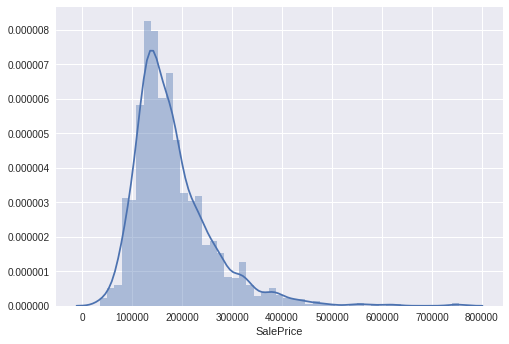

In [11]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_y)

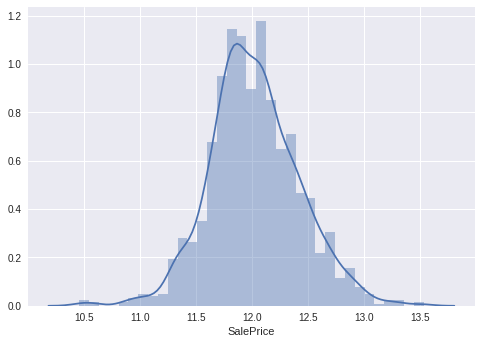

In [12]:
## we can log transform y value
ax = sns.distplot(np.log1p(train_y))
train_y = np.log1p(train_y)

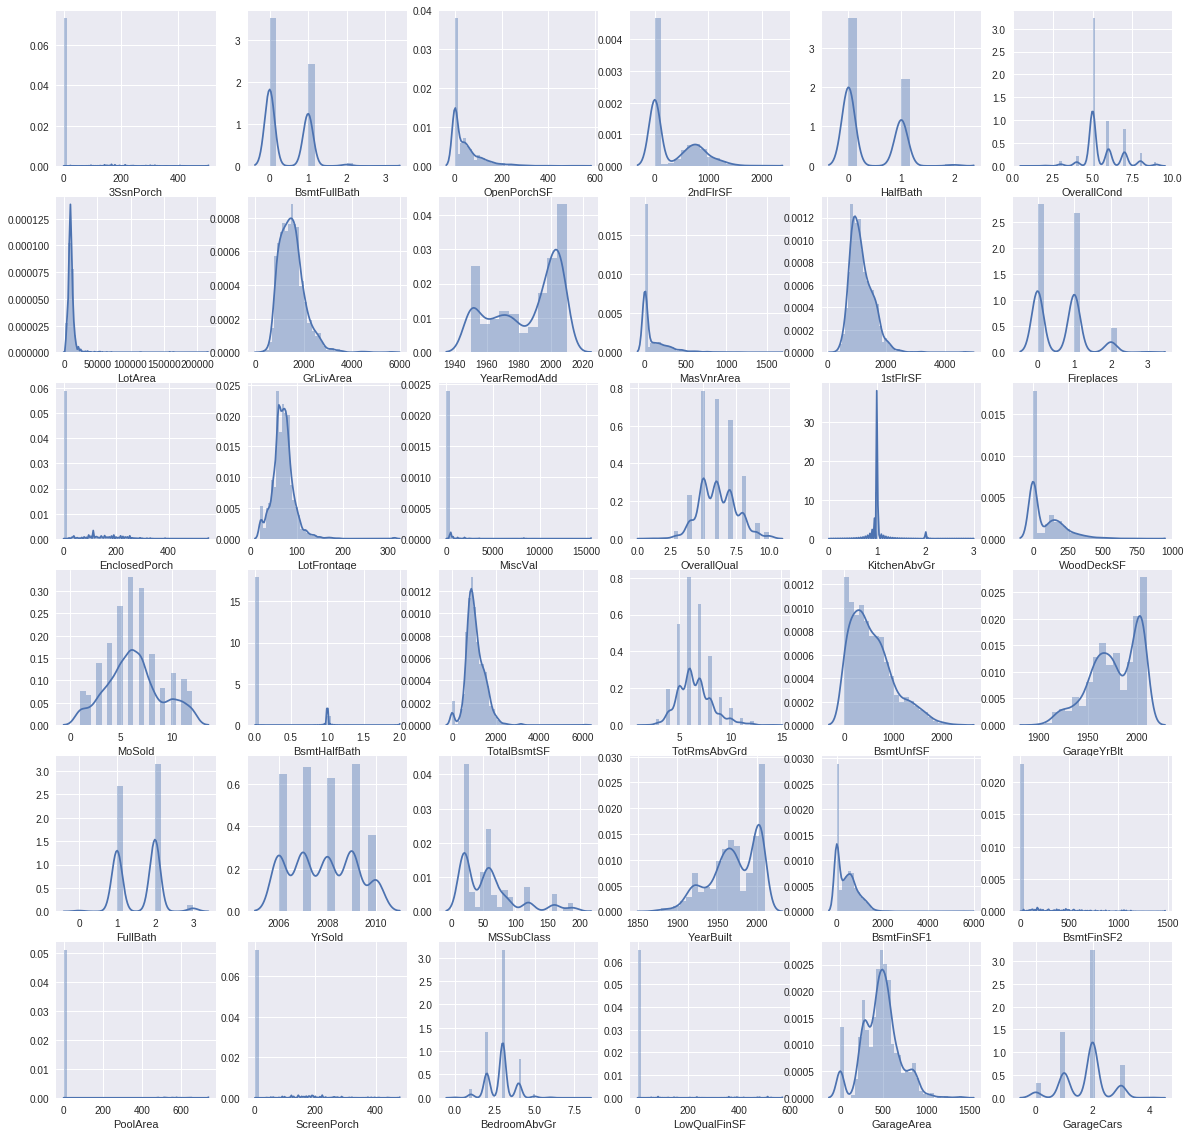

In [13]:
# Similarly, look at other numeric features
rcParams['figure.figsize'] = 20, 20
# take a look of each variable vs y
f, axes = plt.subplots(6,6)
n_iter = 0
for i in range(6):
    for j in range(6):
        sns.distplot(train_filled[num_columns[n_iter]],ax=axes[i][j])
        n_iter += 1

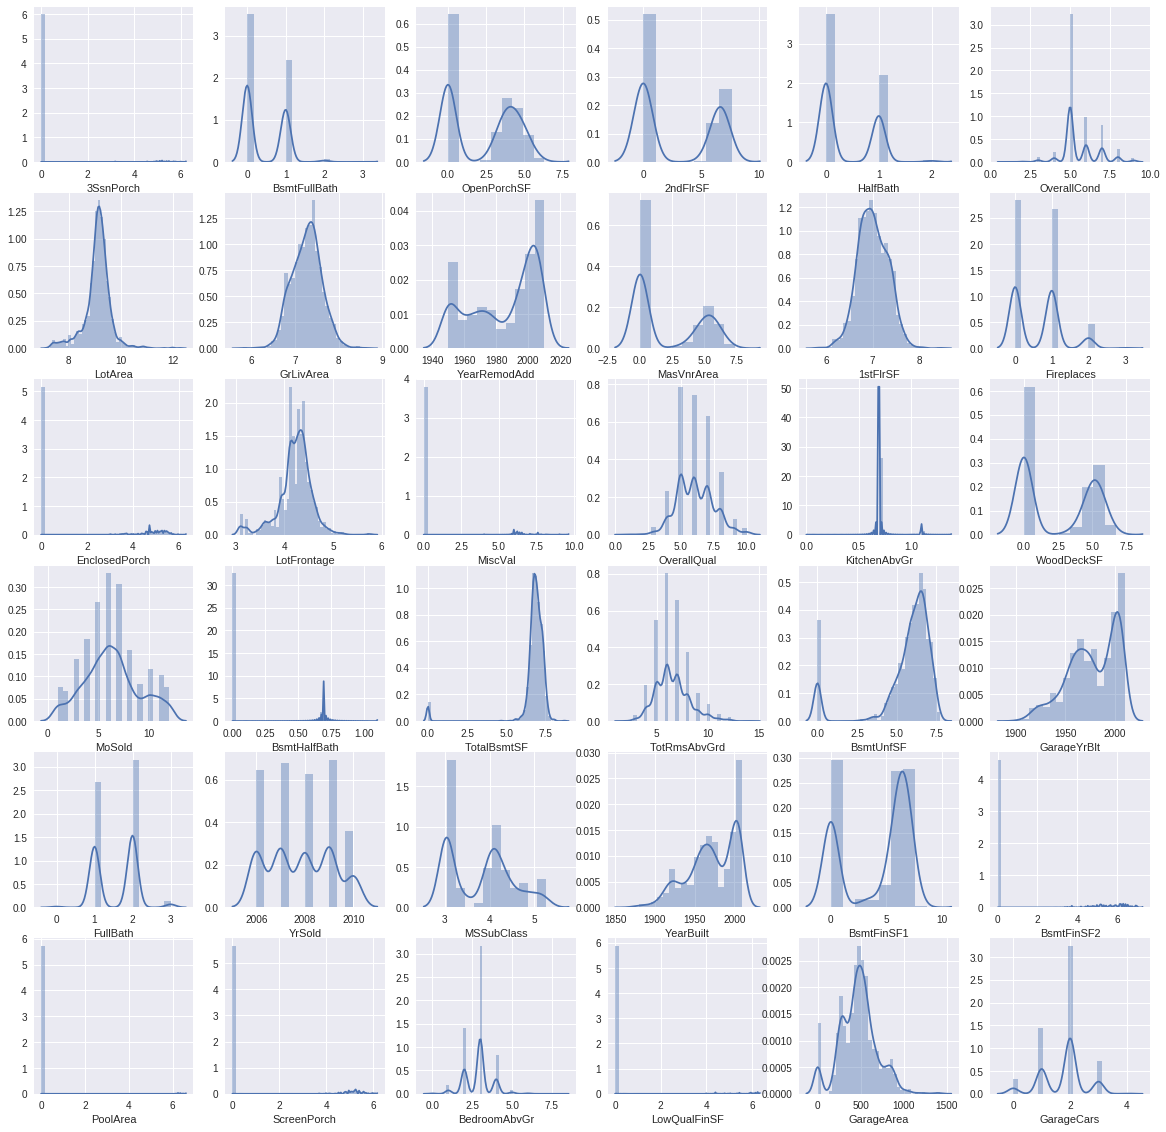

In [14]:
# Skewness
# compute skewness aloong column/feature
skewed_fts = train_filled[num_columns].apply(lambda x: skew(x), axis=0) 
skewed_fts = skewed_fts[np.abs(skewed_fts) > 0.75]
skewed_fts = skewed_fts.index

train_filled[skewed_fts] = np.log1p(train_filled[skewed_fts])
test_filled[skewed_fts] = np.log1p(test_filled[skewed_fts])
# now take a look again
f, axes = plt.subplots(6,6)
n_iter = 0
for i in range(6):
    for j in range(6):
        sns.distplot(train_filled[num_columns[n_iter]],ax=axes[i][j])
        n_iter += 1

In [15]:
# Standarization
# fisrt option: standarize non-categoorical values
std_features = list(set(train_filled.columns)-set(obj_columns))
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
train_filled[std_features] = ss.fit_transform(train_filled[std_features])
test_filled[std_features] = ss.transform(test_filled[std_features])

# second option: standarize all values
# ss = StandardScaler(copy=True, with_mean=True, with_std=True)
# train_filled[train_filled.columns] = ss.fit_transform(train_filled)
# test_filled[test_filled.columns] = ss.transform(test_filled)

In [16]:
train_filled[num_columns].describe()

,3SsnPorch,BsmtFullBath,OpenPorchSF,2ndFlrSF,HalfBath,OverallCond,LotArea,GrLivArea,YearRemodAdd,MasVnrArea,...,MSSubClass,YearBuilt,BsmtFinSF1,BsmtFinSF2,PoolArea,ScreenPorch,BedroomAbvGr,LowQualFinSF,GarageArea,GarageCars
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,...,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,1.314398e-16,-3.741300e-17,-1.525948e-15,4.121513e-16,-3.224209e-17,3.197594e-16,4.911938e-15,-1.518701e-14,4.467051e-15,-4.094138e-16,...,-3.213350e-14,1.052240e-15,1.271890e-15,-1.879775e-16,6.922925e-16,-4.714646e-17,1.854301e-16,-4.372834e-16,7.208845e-17,7.300097e-18
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,...,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-1.285214e-01,-8.199644e-01,-1.072916e+00,-8.701174e-01,-7.616207e-01,-4.112970e+00,-3.751177e+00,-4.365036e+00,-1.689368e+00,-8.147880e-01,...,-1.125202e+00,-3.287824e+00,-1.414140e+00,-3.553424e-01,-6.939258e-02,-2.927694e-01,-3.514952e+00,-1.336023e-01,-2.212963e+00,-2.365440e+00
25%,-1.285214e-01,-8.199644e-01,-1.072916e+00,-8.701174e-01,-7.616207e-01,-5.171998e-01,-3.500987e-01,-7.146000e-01,-8.656586e-01,-8.147880e-01,...,-1.125202e+00,-5.719226e-01,-1.414140e+00,-3.553424e-01,-6.939258e-02,-2.927694e-01,-1.062465e+00,-1.336023e-01,-6.479160e-01,-1.026858e+00
50%,-1.285214e-01,-8.199644e-01,4.413151e-01,-8.701174e-01,-7.616207e-01,-5.171998e-01,8.878817e-02,6.332373e-02,4.425864e-01,-8.147880e-01,...,1.642623e-01,5.737148e-02,5.757928e-01,-3.553424e-01,-6.939258e-02,-2.927694e-01,1.637791e-01,-1.336023e-01,3.284429e-02,3.117246e-01
75%,-1.285214e-01,1.107810e+00,8.949251e-01,1.132102e+00,1.227585e+00,3.817427e-01,4.795310e-01,6.440545e-01,9.271216e-01,1.129497e+00,...,6.450728e-01,9.516316e-01,7.823736e-01,-3.553424e-01,-6.939258e-02,-2.927694e-01,1.637791e-01,-1.336023e-01,4.820057e-01,3.117246e-01
max,9.220415e+00,4.963359e+00,1.857985e+00,1.448517e+00,3.216791e+00,3.078570e+00,6.126490e+00,4.110760e+00,1.217843e+00,1.988200e+00,...,2.083189e+00,1.282839e+00,1.474007e+00,3.600612e+00,1.499282e+01,4.110032e+00,6.294997e+00,8.367142e+00,4.421526e+00,2.988889e+00


In [17]:
train_filled[num_columns].head()

,3SsnPorch,BsmtFullBath,OpenPorchSF,2ndFlrSF,HalfBath,OverallCond,LotArea,GrLivArea,YearRemodAdd,MasVnrArea,...,MSSubClass,YearBuilt,BsmtFinSF1,BsmtFinSF2,PoolArea,ScreenPorch,BedroomAbvGr,LowQualFinSF,GarageArea,GarageCars
0,-0.128521,1.107810,0.845209,1.180528,1.227585,-0.517200,-0.133270,0.529194,0.878668,1.192258,...,0.424462,1.050994,0.779431,-0.355342,-0.069393,-0.292769,0.163779,-0.133602,0.351000,0.311725
1,-0.128521,-0.819964,-1.072916,-0.870117,-0.761621,2.179628,0.113413,-0.381965,-0.429577,-0.814788,...,-1.125202,0.156734,0.888257,-0.355342,-0.069393,-0.292769,0.163779,-0.133602,-0.060731,0.311725
2,-0.128521,1.107810,0.675137,1.184762,1.227585,-0.517200,0.420049,0.659631,0.830215,1.120287,...,0.424462,0.984752,0.654803,-0.355342,-0.069393,-0.292769,0.163779,-0.133602,0.631726,0.311725
3,-0.128521,1.107810,0.592558,1.143550,-0.761621,-0.517200,0.103317,0.541448,-0.720298,-0.814788,...,0.645073,-1.863632,0.384539,-0.355342,-0.069393,-0.292769,0.163779,-0.133602,0.790804,1.650307
4,-0.128521,1.107810,0.991848,1.244087,1.227585,-0.517200,0.878431,1.282295,0.733308,1.411677,...,0.424462,0.951632,0.754400,-0.355342,-0.069393,-0.292769,1.390023,-0.133602,1.698485,1.650307


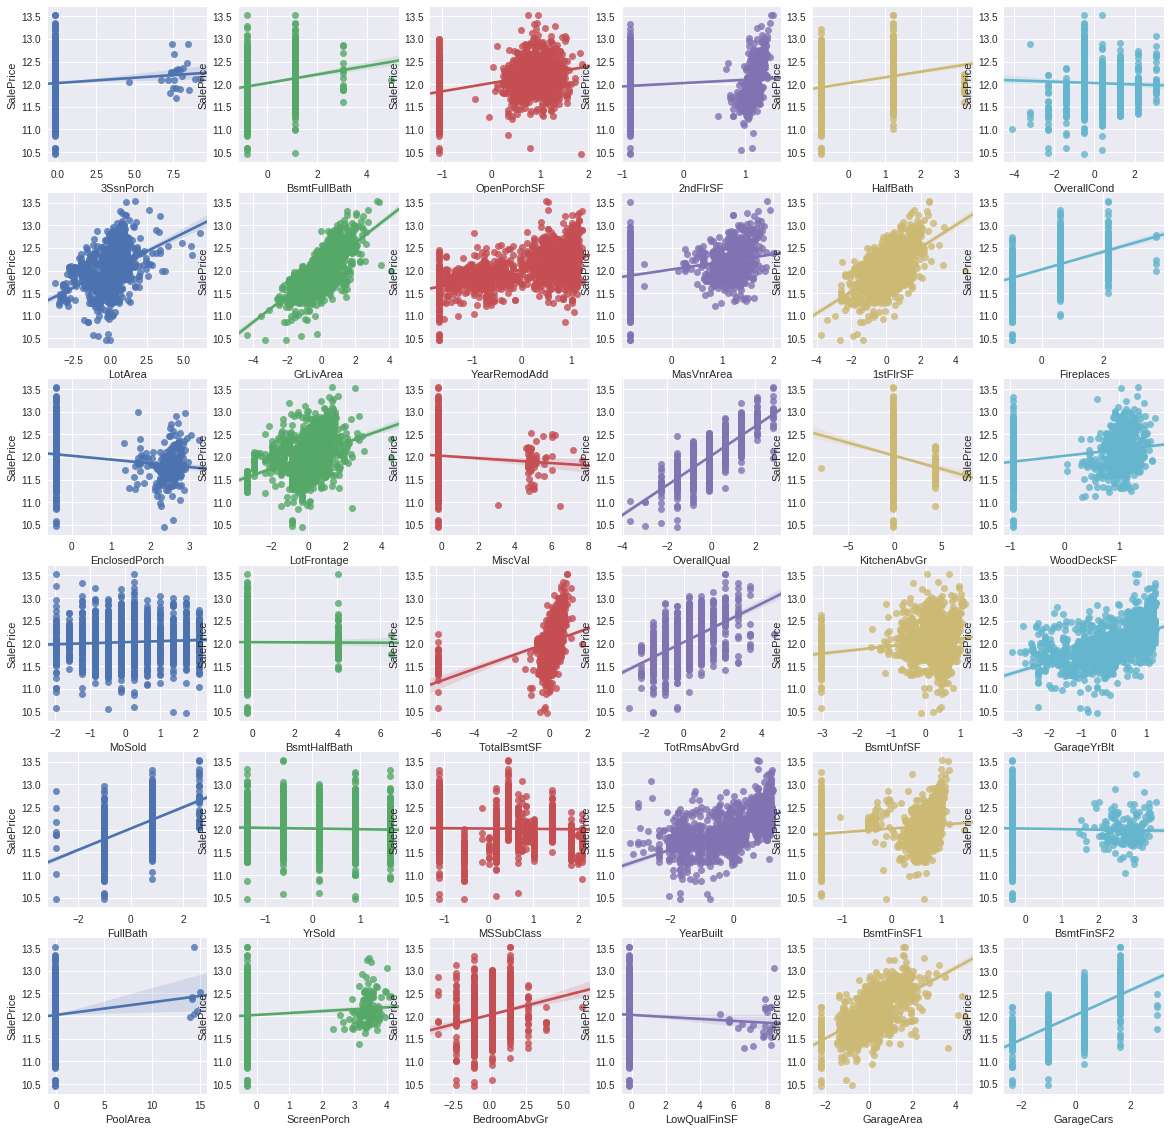

In [18]:
rcParams['figure.figsize'] = 20, 20
# take a look of each variable vs y
f, axes = plt.subplots(6,6)
n_iter = 0
for i in range(6):
    for j in range(6):
        sns.regplot(x=train_filled[num_columns[n_iter]], y=train_y,ax=axes[i][j])
        n_iter += 1

In [19]:
# from above we choose some features to discard
# features_discard = ['3SsnPorch', 'MiscVal', 'PoolArea', 'ScreenPorch', 'LowQualFinSF']
# discard
# train_filled.drop(features_discard, axis = 1, inplace=True)
# test_filled.drop(features_discard, axis = 1, inplace=True)

In [20]:
# ax = sns.pairplot(train_filled[std_features[:5]])

In [21]:
# due to multicollinearity, perform PCA on dataset and see if result improves
n_features = train_filled.shape[1]
print n_features

pca = PCA(n_features)
pca.fit_transform(train_filled)

explained = pca.explained_variance_ratio_
n_use = 70
print sum(explained[:n_use])

pca = PCA(n_use)
train_filled = pca.fit_transform(train_filled)
test_filled = pca.transform(test_filled)

74
0.999620756861


### train regression model

In [22]:
def find_params(train_X, train_Y, test_X, params_found=False, verbose=False):
    if not params_found:
        t1 = time.time()
        param_grid = {'loss': ['ls', 'lad', 'huber'], 
                      'learning_rate':[0.1, 0.05, 0.02, 0.01],
                      'max_depth': [3,4,6],
                      'min_samples_leaf': [3,5,9,17],
                      'max_features': [0.1, 0.3, 1.0]}
        est = ensemble.GradientBoostingRegressor(n_estimators=8000)
        gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(train_X, train_Y)
        t2 = time.time()

        print "Total time used: {}min".format((t2-t1)/60.)
        print gs_cv.best_score_
        print gs_cv.best_params_
    else:
        print "Use previous found best params."
    
# find_params(train_filled.values, train_y.values, test_filled.values, params_found=True, verbose=True)
find_params(train_filled, train_y.values, test_filled, params_found=True, verbose=True)

Use previous found best params.


In [23]:
# use found best params to produce result
def train_predict(train_X, train_Y, test_X, verbose=False):
    n_cv = 300
    prediction = []
    for n_i in range(n_cv):
        if verbose:
            print "[CV {}]".format(n_i)
        x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=42+n_i)
        
#         bst = ensemble.GradientBoostingRegressor(n_estimators=8000, max_features=0.1, loss='huber', 
#                                                  learning_rate=0.01, max_depth=3, min_samples_leaf=3,
#                                                  random_state=42+n_i)
        bst = ensemble.GradientBoostingRegressor(n_estimators=8000, max_features=0.3, loss='huber', 
                                                 learning_rate=0.01, max_depth=3, min_samples_leaf=17,
                                                 random_state=42+n_i)
        bst.fit(x_train, y_train)
        # make prediction
        preds = bst.predict(x_val)
        # convert prediction and validation label back to regular scale
        preds = np.exp(preds)-1
        y_val = np.exp(y_val)-1
        r2 = metrics.r2_score(y_val, preds)
        ms = metrics.mean_squared_error(y_val, preds)
        print "r2:", r2
        print "RMSLE:", np.sqrt(sum((np.log(np.array(preds)+1)-np.log(np.array(y_val)+1))**2)/len(preds))
    #     xgb.plot_importance(bst)
    #     xgb.plot_tree(bst,num_trees=10)

        prediction_i = bst.predict(test_X)
        prediction.append(prediction_i)
    
    print "Done training and predicting."
    
    prediction = np.array(prediction)
#     prediction = np.exp(np.array(prediction))-1
    ensemble_result = []
    n, m = prediction.shape
    p_std = np.std(prediction, axis=0) # along columns
    p_mean = np.mean(prediction, axis=0)
    for i in range(m):
        p_i = prediction[:,i]
        # select predictions that are with 2 std from the mean
        select_i = p_i[(np.abs(p_i-p_mean[i]) < 0.5*p_std[i])]
        ensemble_result.append(np.mean(select_i))
    # transform y back to normal scale
    ensemble_result = np.exp(ensemble_result)-1
    result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble_result})
    result_df.to_csv('./result/result_gb300_pca.csv', index=False)
    return prediction

# all_prediction = train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)
all_prediction = train_predict(train_filled, train_y.values, test_filled, verbose=True)

[CV 0]
r2: 0.828788630832
RMSLE: 0.162012916248
[CV 1]
r2: 0.856506151423
RMSLE: 0.146283413133
[CV 2]
r2: 0.860353308227
RMSLE: 0.135548092962
[CV 3]
r2: 0.877211634692
RMSLE: 0.154802906926
[CV 4]
r2: 0.873995995696
RMSLE: 0.125469279224
[CV 5]
r2: 0.821357533447
RMSLE: 0.144819511321
[CV 6]
r2: 0.810403333057
RMSLE: 0.14536004201
[CV 7]
r2: 0.876340207995
RMSLE: 0.139733673647
[CV 8]
r2: 0.858482665672
RMSLE: 0.150806202262
[CV 9]
r2: 0.839531237281
RMSLE: 0.148111794074
[CV 10]
r2: 0.807230585854
RMSLE: 0.163466873041
[CV 11]
r2: 0.757137790104
RMSLE: 0.157601262666
[CV 12]
r2: 0.81736623623
RMSLE: 0.137784790881
[CV 13]
r2: 0.859554343616
RMSLE: 0.12884814955
[CV 14]
r2: 0.801886778002
RMSLE: 0.161047003624
[CV 15]
r2: 0.865876620519
RMSLE: 0.149454973232
[CV 16]
r2: 0.791922607217
RMSLE: 0.16443039311
[CV 17]
r2: 0.858024990218
RMSLE: 0.137180329872
[CV 18]
r2: 0.788820284485
RMSLE: 0.156965108452
[CV 19]
r2: 0.859651484873
RMSLE: 0.15200001443
[CV 20]
r2: 0.75164828447
RMSLE: 0.

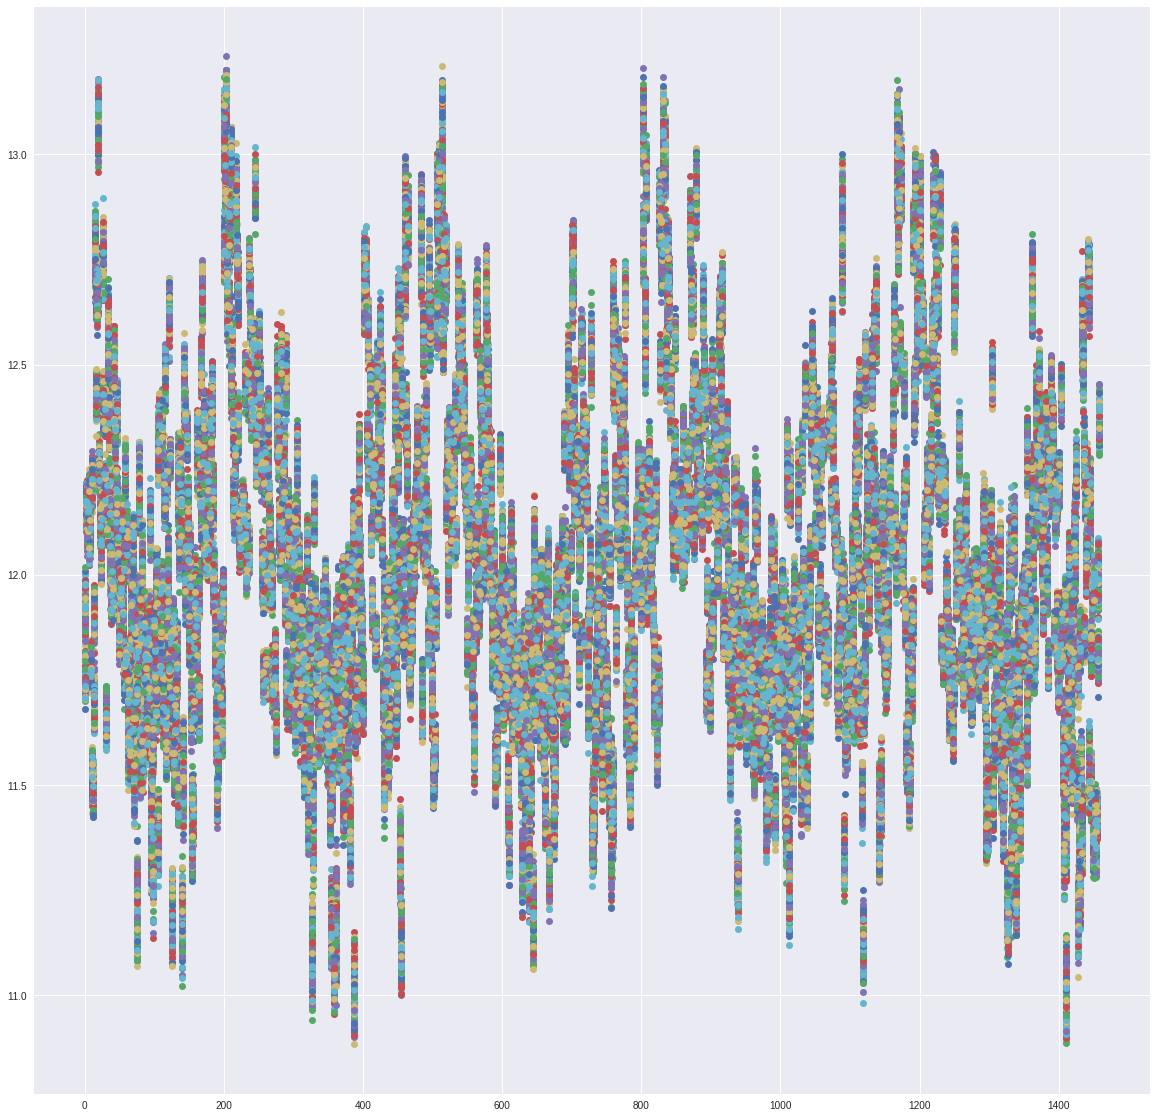

In [24]:
for i in all_prediction:
    plt.plot(range(len(i)), i, 'o')

In [25]:
# def train_predict(train_X, train_Y, test_X, verbose=False):
#     n_cv = 500
#     prediction = []
#     for n_i in range(n_cv):
#         if verbose:
#             print "[CV {}]".format(n_i)
#         x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=42+n_i)
#         lm_i = linear_model.LinearRegression()
#         lm_i.fit(x_train, y_train)
#         acc_i = lm_i.score(x_val, y_val)
#         print acc_i
        
#         prediction_i = lm_i.predict(test_X)
#         prediction.append(prediction_i)
#     print "Done training and predicting."
    
#     prediction = np.array(prediction)
# #     prediction = np.exp(np.array(prediction))
#     ensemble = []
#     n, m = prediction.shape
#     p_std = np.std(prediction, axis=0) # along columns
#     p_mean = np.mean(prediction, axis=0)
#     for i in range(m):
#         p_i = prediction[:,i]
#         select_i = p_i[(np.abs(p_i-p_mean[i]) < 2.*p_std[i]) and (p_i>0.8)]
#         ensemble.append(np.mean(select_i))
#     # transform y back to normal scale
#     ensemble = np.exp(ensemble)
#     result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble})
#     result_df.to_csv('result.csv', index=False)
    
# train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)